### Imports and data loading

In [320]:
import pandas as pd
import backtrader as bt
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Set the path to the root directory
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)

# Load Model 3 prediction file
df = pd.read_csv(path + '/data/predictions/12.csv')

### Data processing

In [321]:
df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'], unit='D')
df = df.dropna()

In [322]:
# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

# Adding intrinsic value as Price on expirty date
# Iterate over every option, which is identified by the combination of Quote_date, Expiry_date, Strike
groups = df.groupby(['Expiry_date', 'Strike'])
for _, group in groups:
    # Create a new row for the date of expiry
    new_row = group.iloc[-1].copy()
    new_row['Price'] = max(0, new_row['Underlying_last'] - new_row['Strike'])
    new_row['TTM'] = 0
    new_row['Quote_date'] = new_row['Expiry_date']
    df = pd.concat([df, new_row.to_frame().transpose()], ignore_index=True)


# Quote_date and Expiry_date to datetime
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])

df_read = df.copy()


### Parameters

In [400]:
buy_threshold = 10
sell_threshold = 15
starting_balance = 1000000

### Functions

In [401]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Price']) >= buy_threshold
    sell_signal = (df['Prediction'] - df['Price']) <= sell_threshold
    return buy_signal, sell_signal

def trader(df, buy_signal, sell_signal, starting_balance):
    # Data
    last_date = df['Quote_date'].max()
    df = df[df['Expiry_date'] < last_date]
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Balance'] = starting_balance
    df["Position_this_opt"] = 0

    # Iterate over every group of options, which is identified by the combination of Expiry_date, Strike
    groups = df.groupby(['Expiry_date', 'Strike'])
    for _, group in groups:
        option_position = 0
        # Iterate over every row in the group
        for index, row in group.iterrows():
            
            # Buy the option
            if row['Signal'] == 1 and option_position == 0 and row['Balance'] >= row['Price'] and df["Balance"].iloc[index:].min() >= row["Price"]:
                option_position = 1
                # Position handling
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Expiry_date'] == row['Expiry_date']) & (df['Strike'] == row['Strike']), 'Position_this_opt'] = option_position
                # Balance handling
                df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] - row['Price']

            # Sell the option
            if row['Signal'] == -1 and option_position == 0:
                option_position = -1
                # Position handling
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Expiry_date'] == row['Expiry_date']) & (df['Strike'] == row['Strike']), 'Position_this_opt'] = option_position
                # Balance handling
                df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] + row['Price']

            # Option expires
            if row["Quote_date"] == row["Expiry_date"] and option_position != 0:
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                adjustment = intrinsic_value if option_position == 1 else -intrinsic_value
                # Adjust balance
                df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] + adjustment        
    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [402]:
df = df_read.copy()
buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
df = trader(df, buy_signal, sell_signal, starting_balance)
df = calculate_options_value(df)

print("Starting balance", starting_balance)
print("Ending balance", df['Balance'].iloc[-1])

Starting balance 1000000
Ending balance 998448.7050000845


### Analysis

In [403]:
import matplotlib.pyplot as plt

def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Set x-axis major ticks to weekly interval, on Mondays
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [404]:
import numpy as np

# Calculate the sharpe ratio of the strategy using the daily returns and using df["R"] as the annualised risk-free rate
def sharpe_ratio(df):
    df["Daily_returns"] = df["Total_value"].pct_change()
    sharpe_ratio = np.sqrt(252) * ((df["Daily_returns"].mean() - (df["R"]/252).mean()) / df["Daily_returns"].std())
    return sharpe_ratio

print("Sharpe ratio", sharpe_ratio(df))

# Calculate max drawdown
def max_drawdown(df):
    df["Drawdown"] = df["Total_value"] / df["Total_value"].cummax() - 1
    max_drawdown = df["Drawdown"].min()
    return max_drawdown

print("Max drawdown", max_drawdown(df))

Sharpe ratio -15.387485196879222
Max drawdown -1.4018743037112409


### Finding best thresholds

Buy threshold 5 Sell threshold 5 Sharpe ratio -5.7947703431286435
Starting balance 1000000 Ending balance 1114271.8250000272


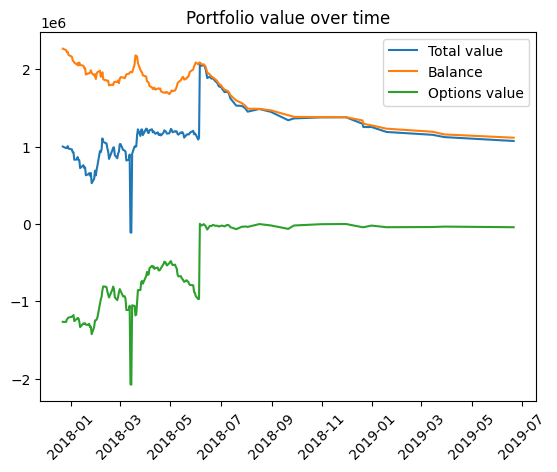

Buy threshold 10 Sell threshold 5 Sharpe ratio -14.203248949500171
Starting balance 1000000 Ending balance 1131075.8500000779


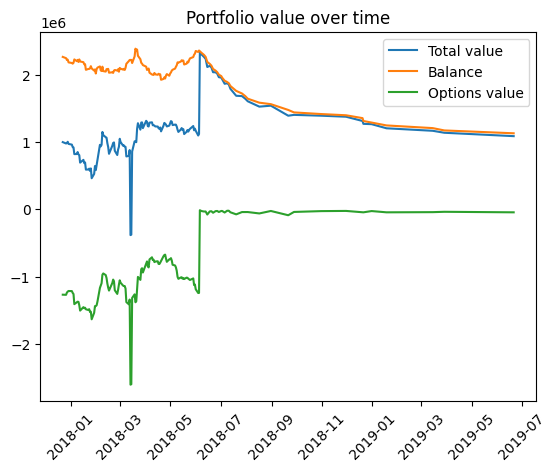

Buy threshold 15 Sell threshold 5 Sharpe ratio -15.32910455758508
Starting balance 1000000 Ending balance 1058143.6200001198


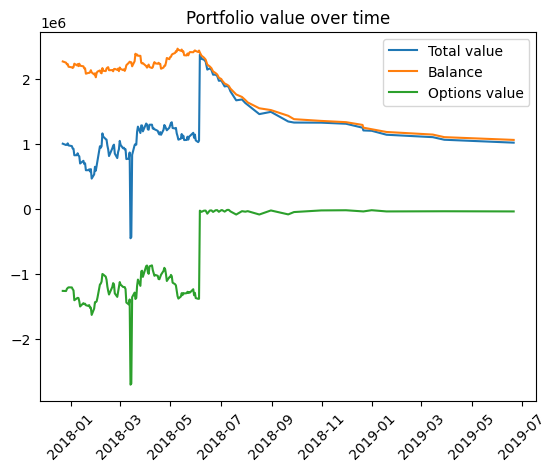

Buy threshold 20 Sell threshold 5 Sharpe ratio -15.709802814807777
Starting balance 1000000 Ending balance 1008524.1200001132


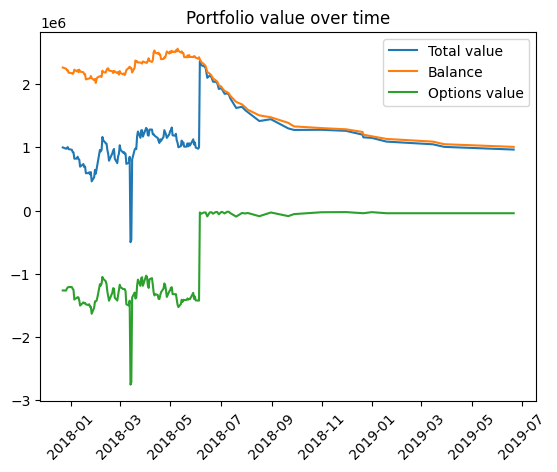

Buy threshold 5 Sell threshold 10 Sharpe ratio -14.55448513419597
Starting balance 1000000 Ending balance 1071574.525000101


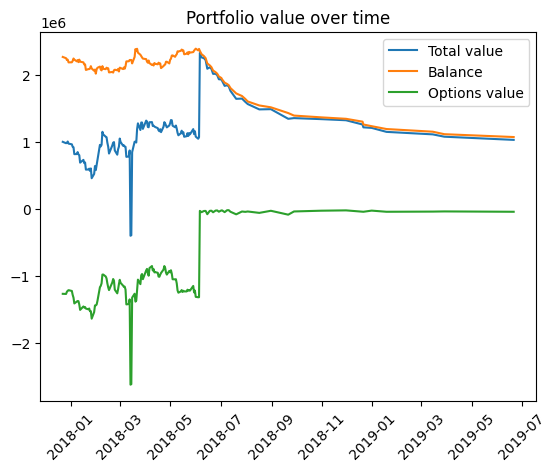

Buy threshold 10 Sell threshold 10 Sharpe ratio -14.55448513419597
Starting balance 1000000 Ending balance 1071574.525000101


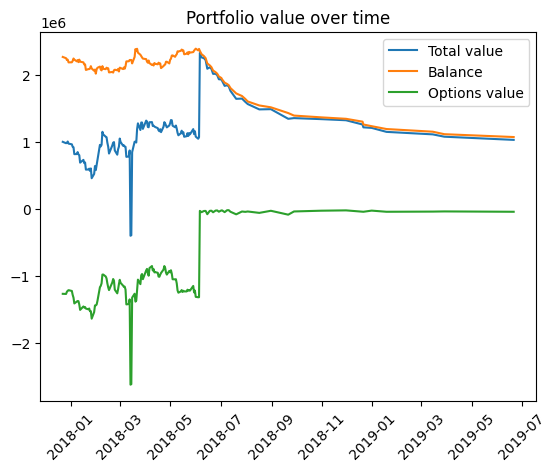

Buy threshold 15 Sell threshold 10 Sharpe ratio -15.437823812337731
Starting balance 1000000 Ending balance 1026665.5650001242


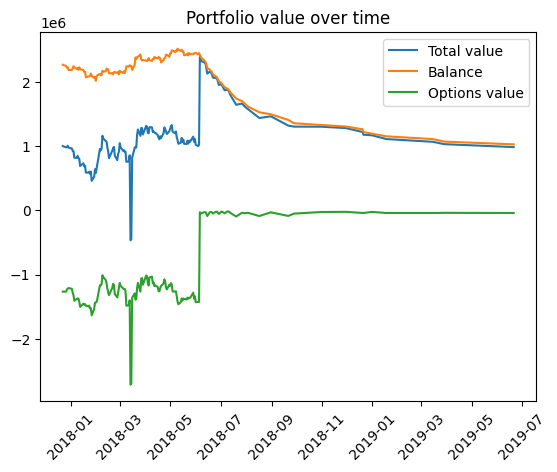

Buy threshold 20 Sell threshold 10 Sharpe ratio -15.79853036183563
Starting balance 1000000 Ending balance 988469.4700000633


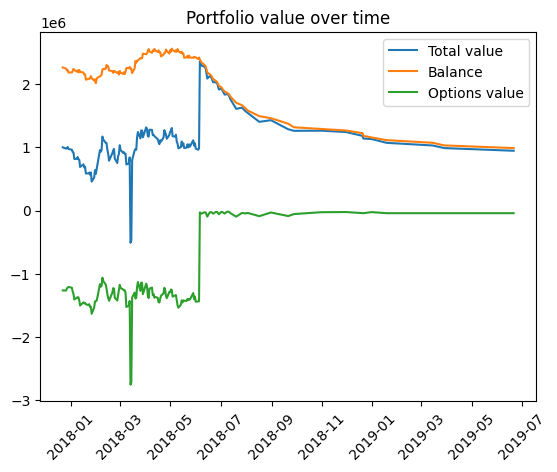

Buy threshold 5 Sell threshold 15 Sharpe ratio -15.387485196879222
Starting balance 1000000 Ending balance 998448.7050000845


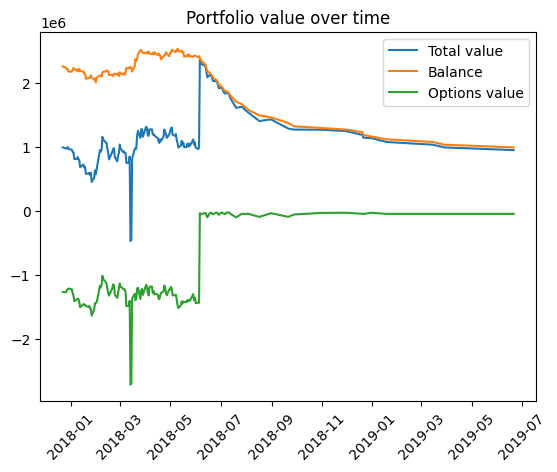

Buy threshold 10 Sell threshold 15 Sharpe ratio -15.387485196879222
Starting balance 1000000 Ending balance 998448.7050000845


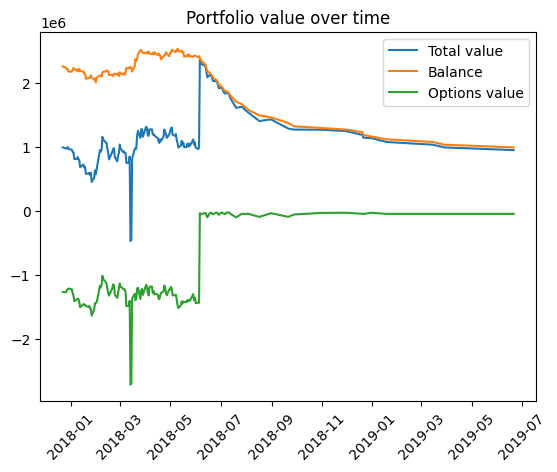

Buy threshold 15 Sell threshold 15 Sharpe ratio -15.387485196879222
Starting balance 1000000 Ending balance 998448.7050000845


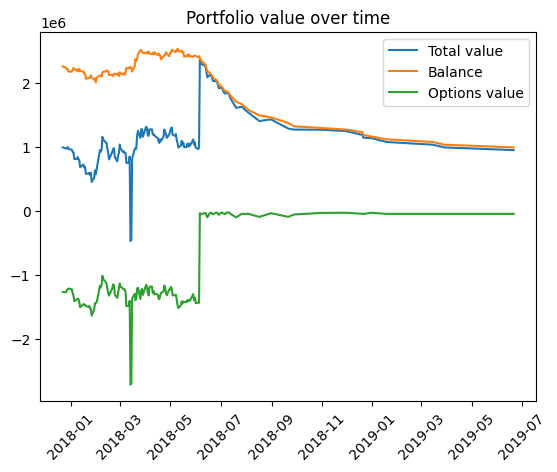

Buy threshold 20 Sell threshold 15 Sharpe ratio -15.728022301501282
Starting balance 1000000 Ending balance 978296.9200000626


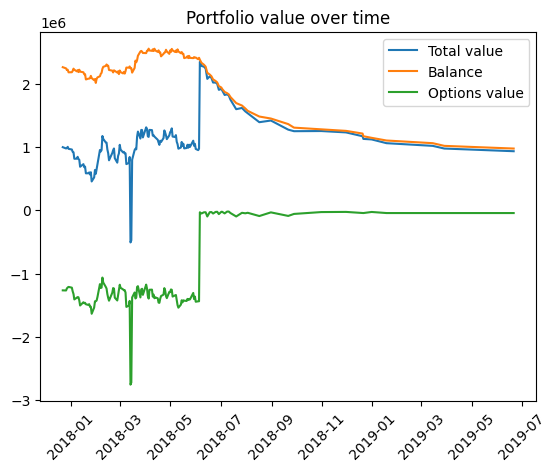

Buy threshold 5 Sell threshold 20 Sharpe ratio -15.738978345139099
Starting balance 1000000 Ending balance 974783.4250000627


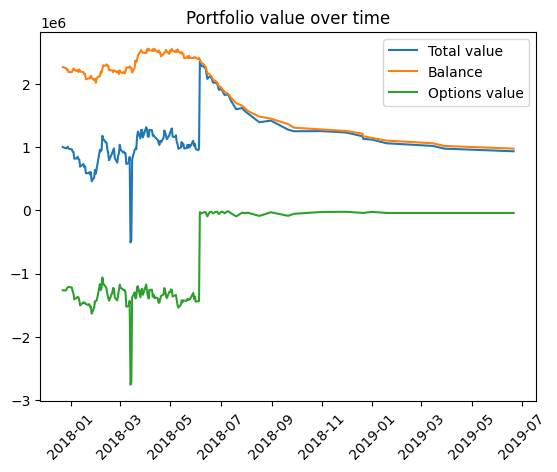

Buy threshold 10 Sell threshold 20 Sharpe ratio -15.738978345139099
Starting balance 1000000 Ending balance 974783.4250000627


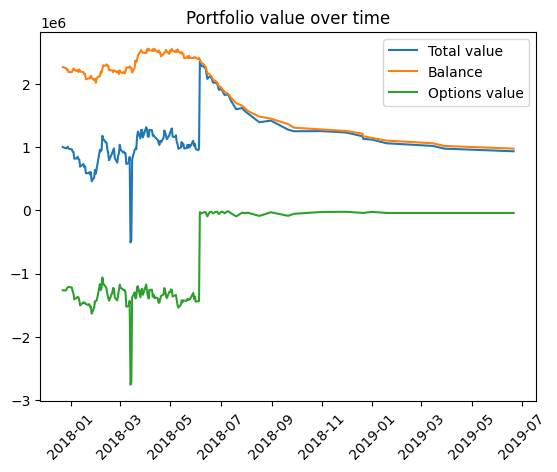

Buy threshold 15 Sell threshold 20 Sharpe ratio -15.738978345139099
Starting balance 1000000 Ending balance 974783.4250000627


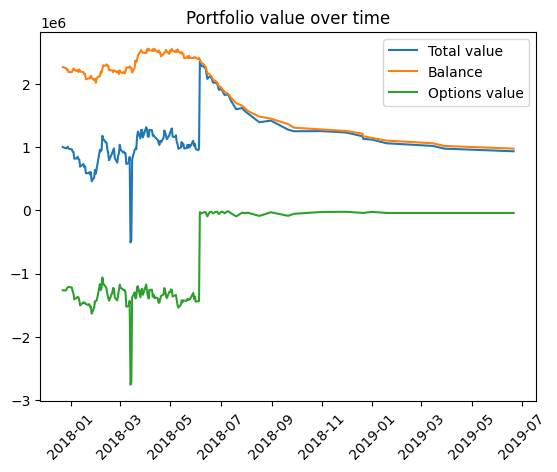

Buy threshold 20 Sell threshold 20 Sharpe ratio -15.738978345139099
Starting balance 1000000 Ending balance 974783.4250000627


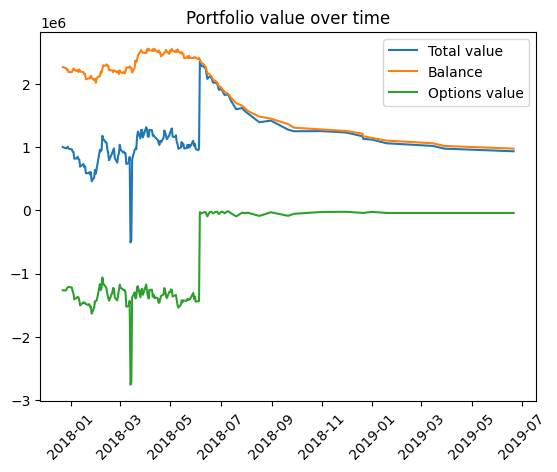

Best Sharpe ratio -5.7947703431286435 Best sell threshold 5 Best buy threshold 5


In [405]:
# Test many conbinations of sell and buy thresholds to find the one that gives the highest Sharpe ratio
def find_best_thresholds(df, starting_balance):
    best_sharpe = -100
    best_sell = 0
    best_buy = 0
    for sell in range(5, 25, 5):
        for buy in range(5, 25, 5):
            df = df_read.copy()
            buy_signal, sell_signal = generate_buy_sell_signals(df, buy, sell)
            df = trader(df, buy_signal, sell_signal, starting_balance)
            df = calculate_options_value(df)
            sharpe = sharpe_ratio(df)
            # Print and plot the results
            print("Buy threshold", buy, "Sell threshold", sell, "Sharpe ratio", sharpe)
            print("Starting balance", starting_balance, "Ending balance", df['Balance'].iloc[-1])
            plot(df)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_sell = sell
                best_buy = buy
    return best_sharpe, best_sell, best_buy

best_sharpe, best_sell, best_buy = find_best_thresholds(df_read, starting_balance)
print("Best Sharpe ratio", best_sharpe, "Best sell threshold", best_sell, "Best buy threshold", best_buy)